In [1]:
from math import * # enables use of pi, trig functions, and more.
from __future__ import division # ensures no rounding errors from division involving integers
import pandas as pd # gives us the dataframe concept
pd.options.display.max_columns = 50
pd.options.display.max_rows = 9

### User Inputs

In [2]:
phi = 40.72
longitude = -77.93
tz = -5
P_mb = 970
Ozone_cm = 0.3
H20_cm = 1.5
AOD500nm = 0.193
AOD380nm = 0.298
Taua = 0.15
Ba = 0.85
albedo = 0.2

In [3]:
G_sc = 1367 # W/m^2
std_mer = longitude-longitude%15+15 # This Standard Meridian calculation is only a guide!! 
                                    # Please double check this value for your location!

### Day of the Year Column

In [4]:
n = range(1,366) # julian day of the year
n_hrly = list(pd.Series(n).repeat(24)) # julian day numbers repeated hourly to create 8760 datapoints in dataset

In [5]:
ds = pd.DataFrame(n_hrly, columns=['DOY']) # create dataframe with julian days 

### Hr of the Day Column

In [6]:
ds['HR'] = [(hr)%24 for hr in ds.index.tolist()] # append dataframe with hr of the day for each day

### Extraterrestrial Radiation

In [7]:
def etr(n):
    return G_sc*(1.00011+0.034221*cos(2*pi*(n-1)/365)+0.00128*sin(2*pi*(n-1)/365)+0.000719*cos(2*(2*pi*(n-1)/365))+0.000077*sin(2*(2*pi*(n-1)/365)))

In [8]:
ds['ETR'] = [etr(n) for n in ds['DOY']] # append dataframe with etr for day

### Intermediate Parameters

In [9]:
ds['Dangle'] = [2*pi*(n-1)/365 for n in ds['DOY']]

In [10]:
def decl(Dangle):
    return (0.006918-0.399912*cos(Dangle)+0.070257*sin(Dangle)-0.006758*cos(2*Dangle)+0.000907*sin(2*Dangle)-0.002697*cos(3*Dangle)+0.00148*sin(3*Dangle))*(180/pi)
ds['DEC'] = [decl(Dangle) for Dangle in ds['Dangle']]

In [11]:
def eqtime(Dangle):
    return (0.0000075+0.001868*cos(Dangle)-0.032077*sin(Dangle)-0.014615*cos(2*Dangle)-0.040849*sin(2*Dangle))*229.18
ds['EQT'] = [eqtime(Dangle) for Dangle in ds['Dangle']]

In [12]:
def omega(hr, eqt):
    return 15*(hr-12.5) + longitude - tz*15 + eqt/4
ds['Hour Angle'] = [omega(hr, eqt) for hr, eqt in zip(ds['HR'],ds['EQT'])]

In [13]:
def zen(dec, hr_ang):
    return acos(cos(dec/(180/pi))*cos(phi/(180/pi))*cos(hr_ang/(180/pi))+sin(dec/(180/pi))*sin(phi/(180/pi)))*(180/pi)
ds['Zenith Ang'] = [zen(dec, hr_ang) for dec, hr_ang in zip(ds['DEC'],ds['Hour Angle'])]

In [14]:
def airmass(zenang):
    if zenang < 89:
        return 1/(cos(zenang/(180/pi))+0.15/(93.885-zenang)**1.25)
    else:
        return 0
ds['Air Mass'] = [airmass(zenang) for zenang in ds['Zenith Ang']]

### Intermediate Results

In [15]:
def T_rayleigh(airmass):
    if airmass > 0:
        return exp(-0.0903*(P_mb*airmass/1013)**0.84*(1+P_mb*airmass/1013-(P_mb*airmass/1013)**1.01))
    else:
        return 0
ds['T rayleigh'] = [T_rayleigh(airmass) for airmass in ds['Air Mass']]

In [16]:
def T_ozone(airmass):
    if airmass > 0:
        return 1-0.1611*(Ozone_cm*airmass)*(1+139.48*(Ozone_cm*airmass))**-0.3034-0.002715*(Ozone_cm*airmass)/(1+0.044*(Ozone_cm*airmass)+0.0003*(Ozone_cm*airmass)**2)
    else:
        return 0
ds['T ozone'] = [T_ozone(airmass) for airmass in ds['Air Mass']]

In [17]:
def T_gasses(airmass):
    if airmass > 0:
        return exp(-0.0127*(airmass*P_mb/1013)**0.26)
    else:
        return 0
ds['T gases'] = [T_gasses(airmass) for airmass in ds['Air Mass']]

In [18]:
def T_water(airmass):
    if airmass > 0:
        return 1-2.4959*airmass*H20_cm/((1+79.034*H20_cm*airmass)**0.6828+6.385*H20_cm*airmass)
    else:
        return 0
ds['T water'] = [T_water(airmass) for airmass in ds['Air Mass']]

In [19]:
def T_aerosol(airmass):
    if airmass > 0:
        return exp(-(Taua**0.873)*(1+Taua-Taua**0.7088)*airmass**0.9108)
    else:
        return 0
ds['T aerosol'] = [T_aerosol(airmass) for airmass in ds['Air Mass']]

In [20]:
def taa(airmass, taerosol):
    if airmass > 0:
        return 1-0.1*(1-airmass+airmass**1.06)*(1-taerosol)
    else:
        return 0
ds['TAA'] = [taa(airmass, taerosol) for airmass, taerosol in zip(ds['Air Mass'],ds['T aerosol'])]

In [21]:
def rs(airmass, taerosol, taa):
    if airmass > 0:
        return 0.0685+(1-Ba)*(1-taerosol/taa)
    else:
        return 0
ds['rs'] = [rs(airmass, taerosol, taa) for airmass, taerosol, taa in zip(ds['Air Mass'],ds['T aerosol'],ds['TAA'])]

In [22]:
def Id(airmass, etr, taerosol, twater, tgases, tozone, trayleigh):
    if airmass > 0:
        return 0.9662*etr*taerosol*twater*tgases*tozone*trayleigh
    else:
        return 0
ds['Id'] = [Id(airmass, etr, taerosol, twater, tgases, tozone, trayleigh) for airmass, etr, taerosol, twater, tgases, tozone, trayleigh in zip(ds['Air Mass'],ds['ETR'],ds['T aerosol'],ds['T water'],ds['T gases'],ds['T ozone'],ds['T rayleigh'])]

In [23]:
def idnh(zenang, Id):
    if zenang < 90:
        return Id*cos(zenang/(180/pi))
    else:
        return 0
ds['IdnH'] = [idnh(zenang, Id) for zenang, Id in zip(ds['Zenith Ang'],ds['Id'])]

In [24]:
def ias(airmass, etr, zenang, tozone, tgases, twater, taa, trayleigh, taerosol):
    if airmass > 0:
        return etr*cos(zenang/(180/pi))*0.79*tozone*tgases*twater*taa*(0.5*(1-trayleigh)+Ba*(1-(taerosol/taa)))/(1-airmass+(airmass)**1.02)
    else:
        return 0
ds['Ias'] = [ias(airmass, etr, zenang, tozone, tgases, twater, taa, trayleigh, taerosol) for airmass, etr, zenang, tozone, tgases, twater, taa, trayleigh, taerosol in zip(ds['Air Mass'],ds['ETR'],ds['Zenith Ang'],ds['T ozone'],ds['T gases'],ds['T water'],ds['TAA'],ds['T rayleigh'],ds['T aerosol'])]

In [25]:
def gh(airmass, idnh, ias, rs):
    if airmass > 0:
        return (idnh+ias)/(1-albedo*rs)
    else:
        return 0
ds['GH'] = [gh(airmass, idnh, ias, rs) for airmass, idnh, ias, rs in zip(ds['Air Mass'],ds['IdnH'],ds['Ias'],ds['rs'])]

### Decimal Time

In [26]:
def dectime(doy, hr):
    return doy+(hr-0.5)/24
ds['Decimal Time'] = [dectime(doy, hr) for doy, hr in zip(ds['DOY'],ds['HR'])]

### Model Results (W/m^2)

In [27]:
ds['Direct Beam'] = ds['Id']

In [28]:
ds['Direct Hz'] = ds['IdnH']

In [29]:
ds['Global Hz'] = ds['GH']

In [30]:
ds['Dif Hz'] = ds['Global Hz']-ds['Direct Hz']

In [31]:
ds

,DOY,HR,ETR,Dangle,DEC,EQT,Hour Angle,Zenith Ang,Air Mass,T rayleigh,T ozone,T gases,T water,T aerosol,TAA,rs,Id,IdnH,Ias,GH,Decimal Time,Direct Beam,Direct Hz,Global Hz,Dif Hz
0,1,0,1414.913350,0.000000,-23.058629,-2.919639,-191.159910,159.997864,0,0,0,0,0,0,0,0,0,0,0,0,0.979167,0,0,0,0
1,1,1,1414.913350,0.000000,-23.058629,-2.919639,-176.159910,162.045308,0,0,0,0,0,0,0,0,0,0,0,0,1.020833,0,0,0,0
2,1,2,1414.913350,0.000000,-23.058629,-2.919639,-161.159910,156.277477,0,0,0,0,0,0,0,0,0,0,0,0,1.062500,0,0,0,0
3,1,3,1414.913350,0.000000,-23.058629,-2.919639,-146.159910,146.587850,0,0,0,0,0,0,0,0,0,0,0,0,1.104167,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8756,365,20,1414.872094,6.265971,-23.130256,-2.468927,108.952768,118.857625,0,0,0,0,0,0,0,0,0,0,0,0,365.812500,0,0,0,0
8757,365,21,1414.872094,6.265971,-23.130256,-2.468927,123.952768,130.205712,0,0,0,0,0,0,0,0,0,0,0,0,365.854167,0,0,0,0
8758,365,22,1414.872094,6.265971,-23.130256,-2.468927,138.952768,141.435302,0,0,0,0,0,0,0,0,0,0,0,0,365.895833,0,0,0,0
8759,365,23,1414.872094,6.265971,-23.130256,-2.468927,153.952768,151.939819,0,0,0,0,0,0,0,0,0,0,0,0,365.937500,0,0,0,0


In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 6  # this sets the default image size for this session

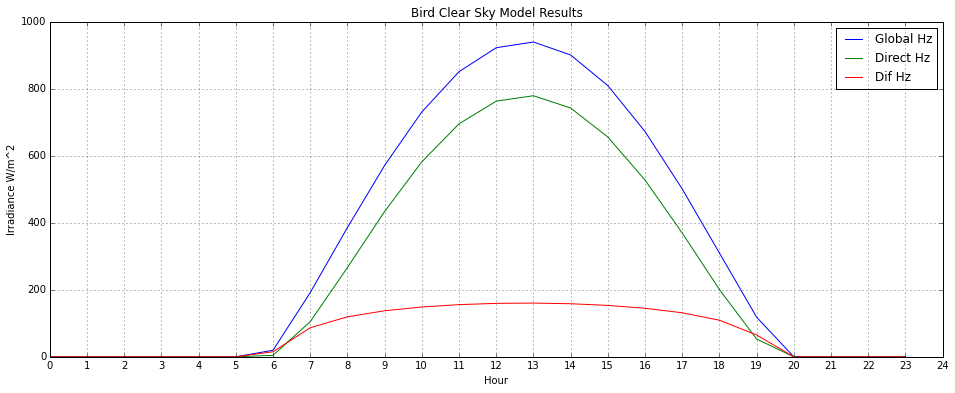

In [33]:
ax = ds[ds['DOY']==212].plot('HR',['Global Hz','Direct Hz','Dif Hz'],title='Bird Clear Sky Model Results')
ax.set_xlabel("Hour")
ax.set_ylabel("Irradiance W/m^2")
majorx = ax.set_xticks(range(0,25,1))
majory = ax.set_yticks(range(0,1001,200))

### SURFRAD Data

In [34]:
initial_cols_list = list(pd.read_table('surfrad_col_headers.txt', sep="\t", skipinitialspace=True, header=None)[0])
qc_flag_cols = ['qc'+str(n) for n in range(1,21)]
col_headers = initial_cols_list[:8] + [item for sublist in zip(initial_cols_list[8:],qc_flag_cols) for item in sublist]

In [35]:
surfrad = pd.read_table('psu07212.dat', skiprows=[0,1], sep=" ", skipinitialspace=True, header=None, names=col_headers)

### Calculate local time and add to surfrad dataframe

In [36]:
surfrad['jday_dt'] = [jday+dt/24 for jday, dt in zip(surfrad['jday'],surfrad['dt'])]

In [37]:
surfrad['Dangle'] = [2*pi*(n-1)/365 for n in surfrad['jday_dt']]

In [38]:
surfrad['DEC'] = [decl(Dangle) for Dangle in surfrad['Dangle']]

In [39]:
surfrad['EQT'] = [eqtime(Dangle) for Dangle in surfrad['Dangle']]

In [40]:
# surfrad['t_local'] = [(dt+tz)+(4*(longitude-std_mer)+eqt)/60 for dt,eqt in zip(surfrad['dt'],surfrad['EQT'])]
surfrad['t_local'] = [(dt+tz+1)+(4*(longitude-std_mer)+eqt)/60 for dt,eqt in zip(surfrad['dt'],surfrad['EQT'])]
# surfrad['t_local'] = [(dt+tz+1) for dt in surfrad['dt']]

In [41]:
surfrad

,year,jday,month,day,hour,min,dt,zen,dw_solar,qc1,uw_solar,qc2,direct_n,qc3,diffuse,qc4,dw_ir,qc5,dw_casetemp,qc6,dw_dometemp,qc7,uw_ir,qc8,uw_casetemp,...,uvb,qc11,par,qc12,netsolar,qc13,netir,qc14,totalnet,qc15,temp,qc16,rh,qc17,windspd,qc18,winddir,qc19,pressure,qc20,jday_dt,Dangle,DEC,EQT,t_local
0,2007,212,7,31,0,0,0.00,85.24,27.8,0,6.0,0,-2.4,0,31.9,0,385.9,0,301.0,0,300.6,0,440.6,0,299.6,...,1.5,0,13.5,0,26.0,0,-54.7,0,-28.7,0,25.6,0,70.8,0,1.2,0,18.2,0,969.7,0,212.000000,3.632198,18.469146,-6.555801,-4.304597
1,2007,212,7,31,0,3,0.05,85.75,21.2,0,4.3,0,-2.9,0,25.2,0,384.6,0,300.8,0,300.4,0,439.0,0,299.5,...,1.3,0,10.9,0,20.9,0,-54.4,0,-33.5,0,25.5,0,71.3,0,1.0,0,9.3,0,969.7,0,212.002083,3.632233,18.468639,-6.555735,-4.254596
2,2007,212,7,31,0,6,0.10,86.26,15.2,0,2.4,0,-2.6,0,18.8,0,384.8,0,300.5,0,300.2,0,437.2,0,299.4,...,1.1,0,8.5,0,16.4,0,-52.4,0,-36.0,0,25.4,0,71.7,0,0.7,0,356.8,0,969.8,0,212.004167,3.632269,18.468132,-6.555668,-4.204594
3,2007,212,7,31,0,9,0.15,86.77,11.6,0,1.1,0,-1.8,0,14.9,0,385.6,0,300.3,0,300.1,0,436.2,0,299.2,...,0.9,0,7.1,0,13.7,0,-50.6,0,-36.8,0,25.3,0,72.6,0,0.5,0,343.3,0,969.8,0,212.006250,3.632305,18.467625,-6.555602,-4.154593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,2007,212,7,31,23,48,23.80,83.31,61.5,0,19.4,0,247.4,0,44.5,0,373.5,0,302.9,0,302.6,0,445.0,0,301.7,...,2.7,0,29.6,0,53.9,0,-71.5,0,-17.6,0,27.2,0,62.9,0,0.4,0,157.6,0,970.2,0,212.991667,3.649268,18.225447,-6.519153,19.496014
477,2007,212,7,31,23,51,23.85,83.83,50.6,0,14.3,0,179.7,0,41.7,0,372.8,0,302.7,0,302.4,0,443.0,0,301.6,...,2.4,0,25.2,0,46.7,0,-70.2,0,-23.5,0,27.2,0,64.1,0,0.2,0,159.2,0,970.2,0,212.993750,3.649304,18.224930,-6.519065,19.546016
478,2007,212,7,31,23,54,23.90,84.36,44.7,0,11.9,0,162.9,0,38.3,0,372.8,0,302.5,0,302.2,0,441.8,0,301.5,...,2.1,0,22.3,0,42.4,0,-69.0,0,-26.6,0,27.4,0,63.6,0,0.2,0,159.2,0,970.2,0,212.995833,3.649340,18.224413,-6.518977,19.596017
479,2007,212,7,31,23,57,23.95,84.88,28.4,0,2.3,0,4.1,0,33.7,0,372.6,0,302.3,0,302.0,0,439.2,0,301.4,...,1.8,0,17.7,0,31.8,0,-66.6,0,-34.8,0,27.3,0,64.3,0,0.2,0,159.2,0,970.2,0,212.997917,3.649376,18.223896,-6.518889,19.646019


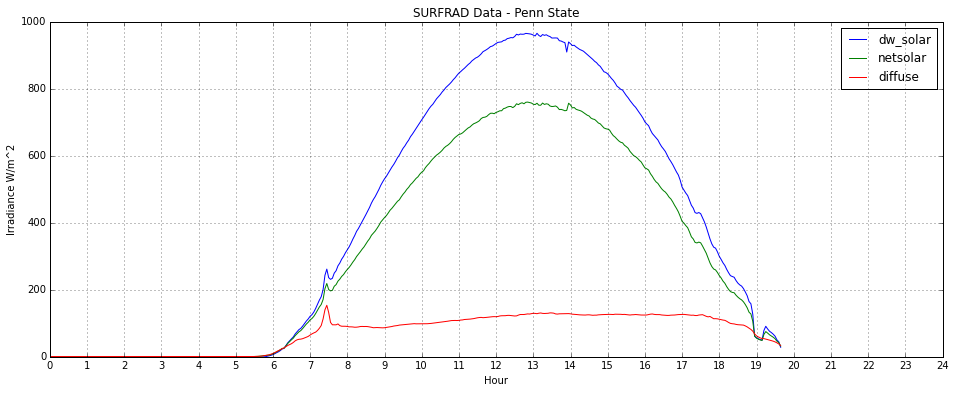

In [42]:
ay = surfrad.plot('t_local',['dw_solar','netsolar','diffuse'],title='SURFRAD Data - Penn State')
ay.set_xlabel("Hour")
ay.set_ylabel("Irradiance W/m^2")
majorx = ay.set_xticks(range(0,25,1))
ay.set_xlim([0,24])
ay.set_ylim(0)
majory = ay.set_yticks(range(0,1001,200))

### Combine the two plots above

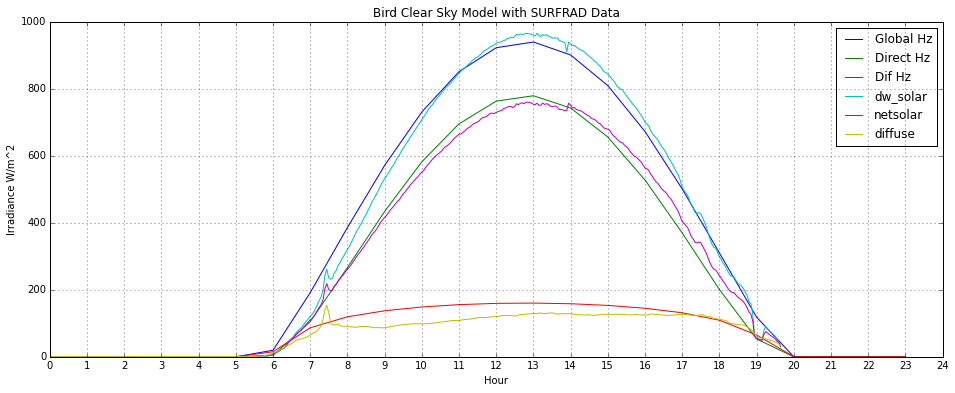

In [43]:
ax = ds[ds['DOY']==212].plot('HR',['Global Hz','Direct Hz','Dif Hz'],title='Bird Clear Sky Model with SURFRAD Data')
ay = surfrad.plot('t_local',['dw_solar','netsolar','diffuse'], ax=ax)
ay.set_xlabel("Hour")
ay.set_ylabel("Irradiance W/m^2")
majorx = ay.set_xticks(range(0,25,1))
ay.set_xlim([0,24])
ay.set_ylim(0)
majory = ay.set_yticks(range(0,1001,200))